In [1]:
import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Model(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers = 1, hidden_dim = 32):
        super(Model, self).__init__()
        self.linear_input = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.ModuleList()
        self.num_hidden_layers = hidden_layers
        for i in range(hidden_layers):
            self.hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.linear_output = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.linear_input(x)
        x = torch.nn.functional.tanh(x)
        for i in range(self.num_hidden_layers):
            x = self.hidden_layers[i](x)
            x = torch.nn.functional.tanh(x)
        x = self.linear_output(x)
        y_pred = x
        return y_pred


class NNR:
    def __init__(self, input_dim, output_dim, hidden_dim=25, hidden_layers=1):
        self._model = Model(input_dim, output_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim)
        self._criterion = nn.MSELoss(size_average = False)
        self._fit_params = dict(lr=0.001, epochs=100, batch_size=256)
        self._optimizer = torch.optim.SGD(self._model.parameters(), lr=self._fit_params['lr'])
        self._losses = None
        self._accuracy = None

    def __repr__(self):
        num = 0
        for k, p in self._model.named_parameters():
            numlist = list(p.data.numpy().shape)
            if len(numlist) == 2:
                num += numlist[0] * numlist[1]
            else:
                num += numlist[0]
        return repr(self._model) + "\n" + repr(self._fit_params) + "\nNum Params: {}".format(num)

    def fit(self, X, y):
        # our loss function is cross entropy loss
        # criterion = torch.nn.CrossEntropyLoss(size_average=True)
        # we are optimizing with SGD with a learning rate of 0.01
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.1)

        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self._fit_params['batch_size'])

        losses = []  # where we'll be storing loss calculations
        batches = 0  # where we'll count the total number of batches
        accuracy = []  # keep track of validation accuracy

        # Training loop
        for epoch in range(self._fit_params['epochs']):
            for i, data in enumerate(train_loader, 0):
                # Forward pass: Compute predicted y by passing x to the model
                predictors, labels = data
                predictors, labels = Variable(predictors.float()), Variable(labels.float())

                pred = self._model.forward(predictors)

                # Compute and store, print loss every 100 cycles
                loss = self._criterion(pred, labels)
                if i % 100 == 0:
                    # print(epoch, i, loss.data[0])
                    losses.append([batches, loss.data[0]])
                    batches += 100

                # Zero gradients, perform a backward pass, and update the weights.
                self._optimizer.zero_grad()
                loss.backward()
                self._optimizer.step()
            accuracy.append([epoch, self.accuracy(y, self.predict(X))])

        # save losses and accuracy as model trains
        self._losses = np.array(losses).T
        self._accuracy = np.array(accuracy).T

    def set_fit_params(self, *, lr=0.001, epochs=50, batch_size=512, l2_weight=0):
        self._fit_params['batch_size'] = batch_size
        self._fit_params['epochs'] = epochs
        self._fit_params['lr'] = lr
        self._fit_params['l2_weight'] = l2_weight
        self._optimizer = torch.optim.SGD(
            self._model.parameters(), lr=self._fit_params['lr'], weight_decay=self._fit_params['l2_weight'])

    def predict(self, X):
        X = Variable(torch.from_numpy(X).float())
        pred = self._model.forward(X)
        return pred.data.numpy()

    def accuracy(self, y, y_hat):
        return np.mean(np.argmax(y, axis = 1) == np.argmax(y_hat, axis = 1))

    def mean_squared_error(self, y, y_hat):
        return mean_squared_error(y, y_hat)

    def r2_score(self, y, y_hat):
        return r2_score(y, y_hat)

In [3]:
mnist = fetch_mldata('MNIST original', data_home='mnist')
mnist.DESCR

'mldata.org dataset: mnist-original'

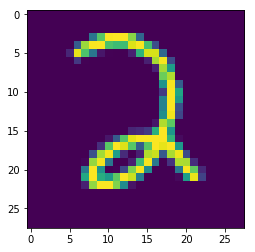

In [4]:
plt.imshow(mnist.data[np.random.choice(mnist.data.shape[0])].reshape((28, 28)))

In [5]:
lb = LabelBinarizer()
lb.fit(mnist.target)
# encode target labels as zero-mean one hot encoded vector 
# with negative class = -0.1 and positive class as 0.9
encode = lambda y: lb.transform(y) - .1

In [6]:
encode([5])

array([[-0.1, -0.1, -0.1, -0.1, -0.1,  0.9, -0.1, -0.1, -0.1, -0.1]])

In [7]:
image_train, image_test, label_train, label_test = train_test_split(
    mnist.data, mnist.target, stratify = mnist.target, random_state = 444, test_size=.15)

X_test = image_test
y_test = encode(label_test)

In [8]:
def get_train_subset(n):
    x, _, y, _ = train_test_split(image_train, label_train, stratify = label_train, random_state=333, train_size = n)
    return x, encode(y)

def do_experiment(nn_width, samle_size):
    X_train, y_train = get_train_subset(samle_size)
    nnr = NNR(784, 10, hidden_dim = 256, hidden_layers = nn_width)
    nnr.fit(X_train, y_train)
    y_hat = nnr.predict(X_test)
    return nnr.accuracy(y_test, y_hat), nnr.mean_squared_error(y_test, y_hat)

In [9]:
sample_sizes = np.array([1000, 5000, 20000, 50000])
results = np.empty((sample_sizes.shape[0], 2))

for i, sample_size in enumerate(sample_sizes):
    results[i, 0],  results[i, 1] = do_experiment(nn_width = 16, samle_size = sample_size)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


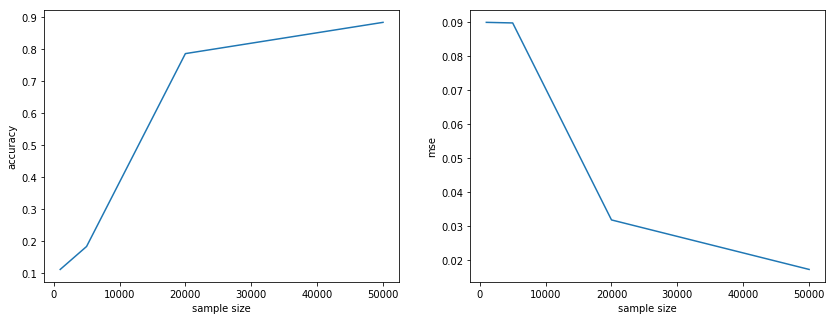

In [18]:
plt.figure(figsize = (14, 5))
plt.subplot(121)
plt.plot(sample_sizes, results[:, 0])
plt.xlabel('sample size')
_ = plt.ylabel('accuracy')
plt.subplot(122)
plt.plot(sample_sizes, results[:, 1])
plt.xlabel('sample size')
_ = plt.ylabel('mse')